# Bayesian Statistics By Example

[Edward Lu](https://github.com/edwardlu71/notebooks)

_This is the note from my several days' study on this interesting topic before the end of my unemployment period! It's a quite difficult topic. I have spent several days on it, still at entry level_

_I am trying to understand the nature of MCMC, so hopefully can construct an example to simulate the behaviour of phase transition of magnetic structure on Ising model, to verify the exciting result developed using renomalization group theory I learnt 35 years ago in school_


## Probability of Multiple Random Variables

### Joint Probability

Probability of events A **and** B, denotes $ P(A\ and\ B), P(A \cap B), P(A, B) $
$$ P(A \cap B) = P(B|A) P(A) =  P(A|B) P(B) $$

### Marginal Probability

Probability of an event for one random variable, irrespective of the outcome of another random variable. 
$$ P(X=A) = \sum_{i}^{all y} P(X=A \cap Y=y_i) $$

### Conditional Probability

Probability of events A **given** B, denotes $ P(A\ given\ B), P(A | B) $

$$ P(A|B) = \frac{P(B|A) P(A)}{P(B)}  $$

In [1]:
# Problem: Suppose there is a school having 60% boys and 40% girls as students. There are 30 Asians students, 20 of them boys and 10 girls
# An observer sees a girl student from a distance. What is the probability this student is an Asian?

# A is the event seeing a girl
# B is the event seeing an Asian
# (A^B) is the probability an Asian girl
# (A|B) is the probability a seen Asian is a girl
# (B|A) is the probability a seen girl is Asian

PA = 40/100       # P(A)
PB = 30/100       # P(B)
PAnB = 10/100     # P(A^B)
PAB = 10/30       # P(A|B)
PBA = 10/40       # P(B|A)

print(round(PAnB,10) == round(PAB*PB, 10))
print(round(PAnB,10) == round(PBA*PA, 10))
print(round(PAB,10) == round(PBA*PA/PB, 10))

True
True
True


## Bayesian Statistics

In regular Markov chain models, we are usually interested in finding the stationary distrtibution $\pi$ for a giving transition T
$$ \large \pi^T T = \pi^T \tag{1}$$

In MCMC, we fix the stationary distribution to be the posterior distribution, and look for a transition kernel $T$ that will converge to this stationary distribution.

$$ \begin{align} 
P(\theta|X) & = \frac{P(X|\theta) P(\theta)}{P(X)} \tag{2} \\
P(X) & = \int d\theta^* P(X|\theta^*) P(\theta^*) 
\end{align} $$

where x is observation, $\theta$ is model with different parameters. Going that way, $P(X|\theta)$ is called **likelihood**; $P(\theta)$ is called **prior probability**. $p(X)$ is a normalizing constant also known as the evidence or marginal likelihood.

**Likelihood** measures the goodness of fit of a statistical model to a sample of data for given values of the unknown parameters

**Prior probability distribution** of an uncertain quantity is the probability distribution **from one's beliefs** about this quantity before some evidence is taken into account. The quantity means paramter of the likelihood model, i.e. $\mu$ or $\sigma$ for a normal distribution. 

**[Conjugate priors](https://en.wikipedia.org/wiki/Conjugate_prior)** when a family of conjugate priors exists, choosing a prior from that family simplifies calculation of the posterior distribution. The wiki link shows the list of conjugate prior cooresponding to the likelihood distributions and model parameters.

**Acceptance ratio** instead of calculating the real value of $P(\theta|X)$, calculate the ration $\large \frac{P(\theta_{1}|X)}{P(\theta_{0}|X)}$ can help to remove the difficult part of $P(X)$ from the formula. When the ratio > 1, that means the parameter $\theta_{1}$ is better fitting the observation than $\theta_{0}$


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex
from IPython.core.display import Image

import seaborn as sns
# settings for seaborn plotting style
sns.set(color_codes=True)
# settings for seaborn plot sizes
sns.set(rc={'figure.figsize':(10, 5)})
#sns.set_context('notebook', font_scale=1.5)

from scipy.stats import uniform, norm, binom, bernoulli, poisson, beta, gamma, boltzmann, expon
import numpy as np
from sympy import init_printing, symbols, simplify, expand, Matrix
init_printing()

## Island hopping Problem

_for the demonstration of Metropolis–Hastings algorithm, learned from the marvelous materies fron Duke university _

a politician visiting a chain of islands to canvas support - being callow, the politician uses a simple rule to determine which island to visit next. Each day, the politician chooses a neighboring island and compares the populations there with the population of the current island. If the neighboring island has a larger population, the politician goes over. If the neighboring island has a smaller population, then the politician visits with probability $\large p = \frac{p_\text{neighbor}}{p_\text{current}}$; otherwise the politician stays on the same island. After doing this for many days, the politician will end up spending time on each island proportional to the population of each island - in other words, estimating the distribution of island populations correctly. 

In [3]:
def make_islands(n, low=10, high=101):
    islands = np.random.randint(low, high, n+2)
    islands[0] = 0
    islands[-1] = 0
    return islands

In [4]:
islands = make_islands(10)
islands

array([ 0, 69, 38, 42, 41, 58, 17, 11, 60, 32, 81,  0])

In [5]:
def hop(islands, start=1, niter=1000):
    pos = start
    pop = islands[pos]
    thetas = np.zeros(niter+1, dtype='int')
    thetas[0] = pos
    for i in range(niter):
        # generate sample from proposal distribution
        k = np.random.choice([-1, 1], 1)
        next_pos = pos + k
        # evaluate unnormalized target distribution at proposed position
        next_pop = islands[next_pos]
        # calculate acceptance probability
        p = min(1, next_pop/pop)
        # use uniform random to decide accept/reject proposal
        if np.random.random() < p:
            pos = next_pos
            pop = next_pop
        thetas[i+1] = pos
    return thetas

In [6]:
thetas = hop(islands, start=1, niter=10000)
len(thetas)

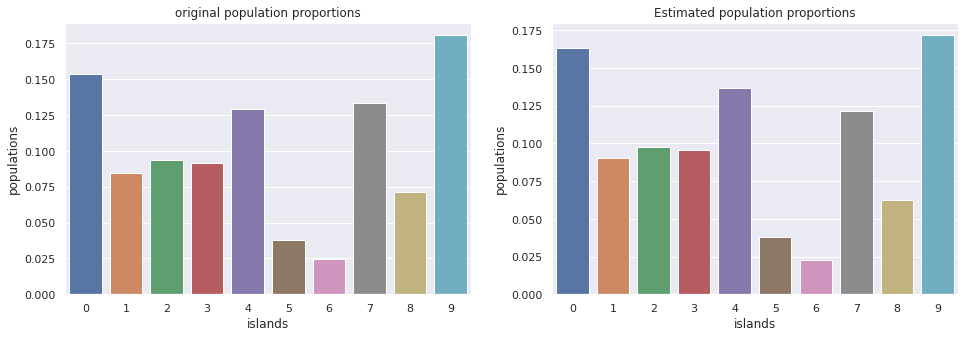

In [7]:
fig, (ax, ax2) = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(16, 5))
data = islands[1:-1]
data = data/data.sum()
sns.barplot(x=np.arange(len(data)), y=data, ax=ax)
_ = ax.set(title='original population proportions', xlabel='islands', ylabel='populations');

data1 = np.bincount(thetas)[1:]
data1 = data1/data1.sum()
sns.barplot(x=np.arange(len(data1)), y=data1, ax=ax2)
_ = ax2.set(title='Estimated population proportions', xlabel='islands', ylabel='populations');

## Generic Theory of Metropolis Hastings Algorithm

(IH = Island Hopping example)

MCMC is a class of methods. Metropolis-Hastings is a specific implementation of MCMC. MCMC allows us to draw samples from a distribution even if we can’t compute it. It can be used to sample from the posterior distribution over parameters.

Suppose we want to sample from a distribution $\pi$, which we will call the _**target**_ distribution. In many cases, it is very difficult to sample directly from the target distribution. The MH algorithm works by simulating a Markov Chain, whose stationary distribution is $\pi$, <font color=yellow>in the long run, the samples from the Markov chain **look like** the samples from $\pi$</font> - _like the distribution of politician staying matching well with the population distribution in IH!_

The implementation of MH is to provide a **transition kernel T(y|x)**, a way randomly moving to y, giving current position x, _like IH moving from current island to next one_. T is called **proposal distribution**. _In IH, it is a **random walk** to a neighbour island where $T(y|x) = choice([-1,1])$_. A more common used continuous distribution is N(0,1), says $ T(y|x) = \large \frac{1}{\sqrt{2\pi}}e^{-\frac{1}{2}(y-x)^2} $ 

The Metropolis Hastings Algorithm is implemented following below steps:
* initial a starting point, say $x_1$ the first island
* for t = 1,2,... i.e. the following days
    * sample y from $T(y|x_i)$, consider y as **proposed** value of $x_{t+1}$
    * compute the **acceptance probabilty** which is normalised between [0,1], _and the distribution $\pi(x)$ is defined as a lambda function **target(x)** in the implementation below_
        $$ A = \min \left( 1, \frac{\pi(y)T(x_t|y)}{\pi(x_t)T(y|x_t)} \right)  $$
        when $T(x_t|y)$ and $T(y|x_t)$ are symmetric, _i.e. in IH they are choice([-1,1]) for both_, it is called **Metropolis Algorithm**
        $$ A = \min \left( 1, \frac{\pi(y)}{\pi(x_t)} \right)  $$
* with probability $A$ randomly accept the proposed value, and set $x_{t+1}=y$. Otherwise set $x_{t+1}=x_t$. _The randome walk function for proposal(x) is defined as a lambda function in the implementation below_




# Markov Chain Monte Carlo Method (MCMC)

Based on Metropolis algorithem learnt, I created an implementation of MCMC method

In [8]:
# Generic MCMC Implementation 
def mcmc(data, start, proposal, prior, acceptance, niter, nburn=0):
    current = start
    post = [current]
    for i in range(niter):
        proposed = proposal(current)
        prior_ratio = prior(proposed, current)
        p = min(acceptance(data, proposed, current, prior_ratio), 1)
        if np.random.random() < p:
            current = proposed
        post.append(current)
    return post[nburn:]

# Example of the definition of proposal and acceptance with likelihood functio
# proposal_width = 0.5
# prior_mu = 0
# prior_sd = 1
# likelihood_sd = 1
# proposal = lambda current: norm(current, proposal_width).rvs()
# prior = lambda proposed, current: norm(prior_mu, prior_sd).pdf(proposed)/norm(prior_mu, prior_sd).pdf(current)
# acceptance = lambda data, proposed, current, prior_ratio: prior_ratio*np.prod(np.array(norm(proposed, likelihood_sd).pdf(data))/np.array(norm(current, likelihood_sd).pdf(data)))

### Generate data samples for the test

The data is generated from normal distribution for the following demonstration. 
*Don't set the sample size higher than 2000. The calculation of long prod for likelihood needs improve, most likely mathematically.*

In [9]:
# Generate Data for test
mu = 1.5
sigma = 1
sample_size = 500
data = norm(mu, sigma).rvs(sample_size)

# the data generated. we pretect not knowing the mu. actually scipy has the function call "fit" to find out the parameters of the data
m, s = norm.fit(data)
print(m, s)

1.5390213592563606 0.9985862010213059


## Run the MCMC Implementation

What do we get? We get the distribution of the predicted $\mu$ from the given data sample. When data sample size increase, we get better posterior distribution indicating higher certainty of the model parameter(s)

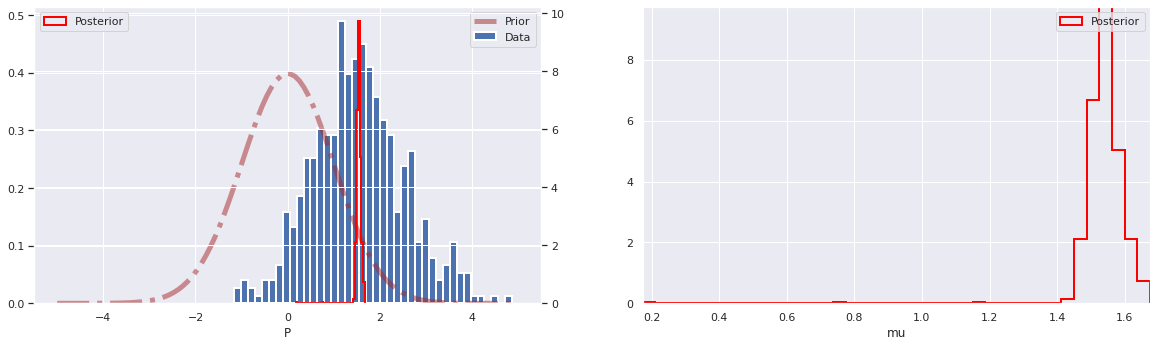

In [10]:
# define the proposal and the acceptance with likelihood function
proposal_width = 0.5
prior_mu = 0
prior_sd = 1
likelihood_sd = 1
proposal = lambda current: norm(current, proposal_width).rvs()
prior = lambda proposed, current: norm(prior_mu, prior_sd).pdf(proposed)/norm(prior_mu, prior_sd).pdf(current)
acceptance = lambda data, proposed, current, prior_ratio: prior_ratio*np.prod(np.array(norm(proposed, likelihood_sd).pdf(data))/np.array(norm(current, likelihood_sd).pdf(data)))

# Feed the data to analyze the certainty of mu. More sample data will result sharper posterior distribution, with higher certainty 
post = mcmc(data, 0.1, proposal, prior, acceptance, niter=1000, nburn=5)

fig = plt.subplots(figsize=(20, 12))
ax = plt.subplot(2, 2, 1)
ax.set_xlabel("P")
ax.hist(data, 40, density=True, linewidth=2, label='Data');
prior_x = np.linspace(-5, 5, 100)
prior_y = norm(prior_mu, prior_sd).pdf(prior_x)
ax.plot(prior_x, prior_y, c='brown', linestyle='-.', alpha=0.5, label='Prior', lw=5)
ax3 = ax.twinx()
ax3.hist(post, 40, histtype='step', color='red', density=True, linewidth=2, label='Posterior');

leg = ax.legend()
leg = ax3.legend(loc='upper left')

ax2 = plt.subplot(2, 2, 2)
ax2.set_xlabel("mu")
ax2.hist(post, 40, histtype='step', color='red', density=True, linewidth=2, label='Posterior');

leg = ax2.legend()

plt.autoscale(tight=True)